<a href="https://colab.research.google.com/github/konradbachusz/tensorflow-notes/blob/master/RNN_ImageClassification_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification with Recurrent Neural Networks

Modified from original source code here: https://github.com/ageron/handson-ml/blob/master/14_recurrent_neural_networks.ipynb

### Make the notebook compatible with both Python 2 and 3

http://python-future.org/compatible_idioms.html

In [0]:
from __future__ import absolute_import, division, print_function

In [2]:
!pip uninstall tensorflow

Uninstalling tensorflow-2.1.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python2.7/dist-packages/tensorflow-2.1.0.dist-info/*
    /usr/local/lib/python2.7/dist-packages/tensorflow/*
    /usr/local/lib/python2.7/dist-packages/tensorflow_core/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.1.0


In [3]:
!pip install tensorflow==1.5

     |████████████████████████████████| 44.4MB 96kB/s 
     |████████████████████████████████| 3.0MB 41.1MB/s 
     |████████████████████████████████| 890kB 40.7MB/s 
  Created wheel for html5lib: filename=html5lib-0.9999999-cp27-none-any.whl size=107221 sha256=a2d5eac68a1d1e28b3752c22996879f55e019ee133f3276f9a50838cc47e9b7d
  Stored in directory: /root/.cache/pip/wheels/50/ae/f9/d2b189788efcf61d1ee0e36045476735c838898eef1cad6e29
Successfully built html5lib
ERROR: fastai 0.7.0 has requirement torch<0.4, but you'll have torch 1.4.0 which is incompatible.
  Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Found existing installation: bleach 3.1.0
    Uninstalling bleach-3.1.0:
      Successfully uninstalled bleach-3.1.0


### Plot graphs inline

In [0]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


In [7]:
print(tf.__version__)
print(np.__version__)
print(matplotlib.__version__)

1.5.0
1.16.4
2.2.4


### Download and extract the MNIST libraries

The original site where this dataset is available: http://yann.lecun.com/exdb/mnist/

In [8]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data

# Store the MNIST data in mnist_data/
mnist = input_data.read_data_sets("mnist_data/")

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting mnist_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting mnist_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting mnist_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting mnist_data/t10k-labels-idx1-ubyte.gz


### Helper function to display one digit image

Reshape the data from 1-D array to a 2-D array of 28x28 pixels

In [0]:
def display_digit(digit):
    plt.imshow(digit.reshape(28, 28), cmap="Greys", interpolation='nearest')

### Access the test data and the corresponding labels

Training data we'll access in batches when we execute this code

In [0]:
test_digits, test_labels = mnist.test.next_batch(200)

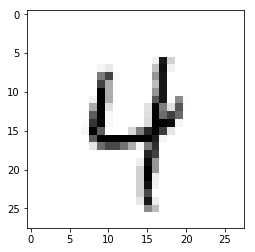

In [11]:
display_digit(test_digits[1])

In [12]:
test_labels[:5]

array([9, 4, 0, 0, 9], dtype=uint8)

### Set up the RNN

* *n_steps* is the number of time instances we want to consider, one dimension of the MNIST is assumed to be time instances
* *n_inputs* is the input for each time instance, this is the second dimension of the MNIST image
* Imagine **one row of pixels in the image is fed at every time instance**
* We use 150 neurons within each RNN memory cell
* The final output is a classification into digits 0-9

In [0]:
n_steps = 28 #number of time instances
n_inputs = 28
n_neurons = 150
n_outputs = 10

In [0]:
tf.reset_default_graph()

### Placeholders for training data and labels

* The inputs to an RNN will be of the form *[batch_size, n_steps, n_inputs]*, the number of time instances and the inputs for every instance are the second and third dimensions
* The labels are 0-9 

In [0]:
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

### Create a basic memory cell and dynamically build the RNN

* Specify the number of neurons in each cell
* *dynamic_rnn* allows you to feed the data in the form *[batch_size, n_steps, n_inputs]* directly to the neural network (reshaping and stacking the data is done internally)
* The result is the final outputs and the internal states of the RNN

In [0]:
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

### Connect the output layer

* Use a dense layer with no activation
* The softmax activation function is applied as a part of the cross-entropy cost function

In [0]:
logits = tf.layers.dense(states, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,logits=logits)

In [0]:
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
training_op = optimizer.minimize(loss)

### Check correctness and accuracy of the prediction

* Check whether the highest probability output in logits is equal to the y-label
* Check the accuracy across all predictions (How many predictions did we get right?)

In [0]:
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [0]:
init = tf.global_variables_initializer()

### Reshape the test digits

The inputs to an RNN will be of the form *[batch_size, n_steps, n_inputs]*, the number of time instances and the inputs for every instance are the second and third dimensions

In [0]:
test_digits = test_digits.reshape((-1, n_steps, n_inputs))

### Train and evaluate the model

In [22]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: test_digits, y: test_labels})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)


0 Train accuracy: 0.9 Test accuracy: 0.955
1 Train accuracy: 0.96 Test accuracy: 0.97
2 Train accuracy: 0.9533333 Test accuracy: 0.975
3 Train accuracy: 0.94 Test accuracy: 0.975
4 Train accuracy: 0.98 Test accuracy: 0.985
5 Train accuracy: 0.9866667 Test accuracy: 0.975
6 Train accuracy: 0.97333336 Test accuracy: 0.98
7 Train accuracy: 0.9866667 Test accuracy: 0.975
8 Train accuracy: 0.96666664 Test accuracy: 1.0
9 Train accuracy: 0.9533333 Test accuracy: 0.99
